In [12]:
from math import ceil
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

Assumptions made 
1. Use recidivism in favor of violent_recidivism 
2. Drop violent recidivismm statistics in prediction and training

In [13]:
import os
filename = "compas-scores-two-years.csv"
assert(filename in os.listdir())

all_cols = pd.read_csv(filename, nrows=0).columns.tolist()
columns = ["c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]

# age: The age of the defendant at the time of the COMPAS assessment
# c_charge_degree: The severity of the current charge
# race: The self-reported race of the defendant
# sex: The gender of the defendant
# priors_count: The number of prior criminal offenses the defendant has
# days_b_screening_arrest: The number of days between the arrest and the COMPAS screening date
# decile_score: This is the actual COMPAS score
# score_text: The categorical label for the decile_score



date_cols = ["c_jail_in", "c_jail_out"]

df = pd.read_csv(filename, usecols=columns, parse_dates=date_cols)
df.columns

Index(['sex', 'age_cat', 'race', 'decile_score', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_charge_degree',
       'is_recid', 'score_text', 'two_year_recid'],
      dtype='object')

In [14]:
np.random.seed(40)

# filter entries to ones that have valid predictions, and were screened 30 days between preditction, and have date of pred less than date of the crime
# https://mlr3fairness.mlr-org.com/reference/compas.html
df = df[
       ( df["is_recid"] != -1) 
       & (abs(df["days_b_screening_arrest"] ) < 30)
       & (df["c_charge_degree"] != "O")
       & (df["decile_score"] != -1)
       & (df["score_text"] != "NaN") ] 

df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6159 entries, 0 to 6158
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sex                      6159 non-null   object        
 1   age_cat                  6159 non-null   object        
 2   race                     6159 non-null   object        
 3   decile_score             6159 non-null   int64         
 4   priors_count             6159 non-null   int64         
 5   days_b_screening_arrest  6159 non-null   float64       
 6   c_jail_in                6159 non-null   datetime64[ns]
 7   c_jail_out               6159 non-null   datetime64[ns]
 8   c_charge_degree          6159 non-null   object        
 9   is_recid                 6159 non-null   int64         
 10  score_text               6159 non-null   object        
 11  two_year_recid           6159 non-null   int64         
dtypes: datetime64[ns](2), float64(1), 

In [15]:
print(df["race"].value_counts())
print(df["age_cat"].value_counts())

race
African-American    3172
Caucasian           2095
Hispanic             508
Other                342
Asian                 31
Native American       11
Name: count, dtype: int64
age_cat
25 - 45            3523
Less than 25       1346
Greater than 45    1290
Name: count, dtype: int64


In [16]:
# convert categories to numerical representations

df["current_jailtime_days"] = (df["c_jail_out"] - df["c_jail_in"]).dt.total_seconds().div(86400).fillna(0).apply(lambda x: ceil(x))
df.drop(["c_jail_in", "c_jail_out", "days_b_screening_arrest"], inplace=True, axis=1)
df["race"] =  df["race"].apply(lambda x: 1 if (x == "African-American") else 0)
df["sex"] = df["sex"].apply(lambda x: 1 if (x == "Male") else 0)
df["age_cat"] = df["age_cat"].apply(lambda x: 1 if (x == "25 - 45") else 0)
df["c_charge_degree"] = df["c_charge_degree"].apply(lambda x: 1 if (x == "M") else 0)
df["score_text"] = df["score_text"].apply(lambda x: 2 if (x == "High") else 1 if (x == "Medium") else 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6159 entries, 0 to 6158
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   sex                    6159 non-null   int64
 1   age_cat                6159 non-null   int64
 2   race                   6159 non-null   int64
 3   decile_score           6159 non-null   int64
 4   priors_count           6159 non-null   int64
 5   c_charge_degree        6159 non-null   int64
 6   is_recid               6159 non-null   int64
 7   score_text             6159 non-null   int64
 8   two_year_recid         6159 non-null   int64
 9   current_jailtime_days  6159 non-null   int64
dtypes: int64(10)
memory usage: 481.3 KB


In [17]:
df.head(10)

,sex,age_cat,race,decile_score,priors_count,c_charge_degree,is_recid,score_text,two_year_recid,current_jailtime_days
0,1,0,0,1,0,0,0,0,0,1
1,1,1,1,3,0,0,1,0,1,11
2,1,0,1,4,4,0,1,0,1,2
3,1,1,0,1,0,1,0,0,0,2
4,1,1,0,6,14,0,1,1,1,7
5,1,1,0,4,3,0,0,0,0,1
6,0,1,0,1,0,1,0,0,0,3
7,1,1,0,4,0,0,0,0,0,2
8,1,0,1,6,3,1,1,1,1,5
9,0,1,0,1,0,1,0,0,0,1


In [18]:
# replicating propublica's research - NO MODEL

analysis = df[['race', 'score_text', 'two_year_recid']]

# ASSUMPTION: score_text scales linear for danger
# csv = pd.get_dummies(analysis ,columns=['score_text', 'race'])

non_recid = analysis[analysis['two_year_recid'] == 0]
total_non_recid = non_recid['race'].value_counts()
fpr = non_recid[non_recid['score_text'].isin([1, 2])]
fpr_by_race = fpr['race'].value_counts()

fpr_AA = fpr_by_race[1] / total_non_recid[1]
fpr_non_AA = fpr_by_race[0] / total_non_recid[0]
fpr_AA, fpr_non_AA

print(f"False Positive Rate for African-American defendants: {fpr_AA:.2%}")
print(f"False Positive Rate for Caucasian defendants: {fpr_non_AA:.2%}")

False Positive Rate for African-American defendants: 42.34%
False Positive Rate for Caucasian defendants: 20.36%


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# simple logistic regression model
X, y = df.drop(['two_year_recid', 'decile_score', 'score_text'], axis=1), df['decile_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

numerical_cols = X_train.select_dtypes(include=np.number).drop(['race'], axis=1).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_test.head()
y_train.head()

,sex,age_cat,race,priors_count,c_charge_degree,is_recid,current_jailtime_days
534,0.474409,0.874846,0,-0.475064,-0.736476,-0.970061,-0.289327
616,0.474409,-1.143058,1,-0.689178,-0.736476,1.030863,-0.268194
5121,-2.107886,0.874846,0,-0.689178,-0.736476,1.030863,-0.268194
1964,0.474409,-1.143058,0,-0.475064,-0.736476,1.030863,-0.204797
5477,0.474409,0.874846,1,1.666075,1.357817,-0.970061,-0.310460


In [20]:
model = LogisticRegression(max_iter=1000, random_state=101)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=101)

In [21]:
X_test['score_text'] = y_test
positive_predictions = X_test[X_test['race'] == 1]
positive_predictions = positive_predictions.drop(['score_text'], axis=1)
S = model.predict(positive_predictions)

counterfactual_X = positive_predictions.copy()
counterfactual_X['race'] = 0
S_hat = model.predict(counterfactual_X)

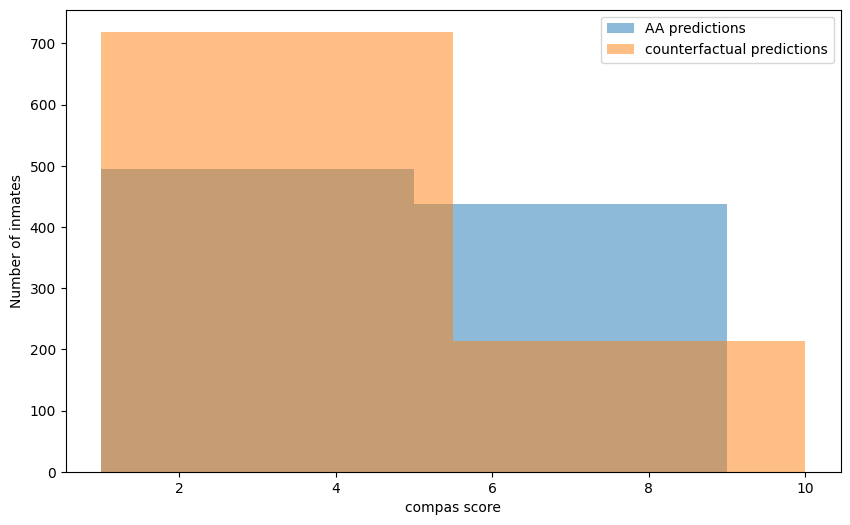

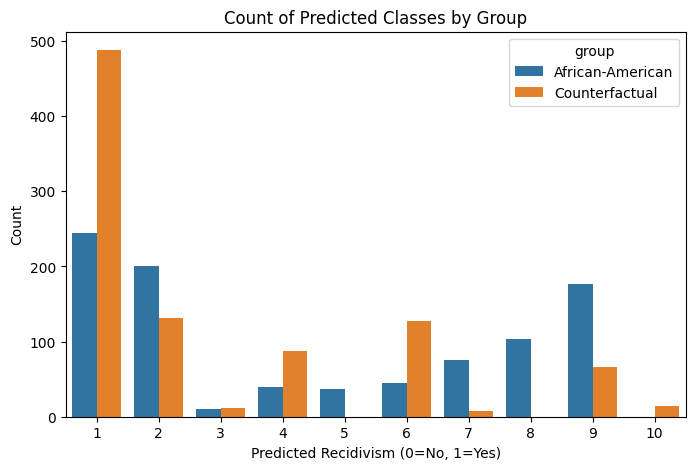

In [22]:
plt.figure(figsize=(10, 6))

plt.hist(S, bins=2, alpha=0.5, label='AA predictions')
plt.hist(S_hat, bins=2, alpha=0.5, label='counterfactual predictions')

plt.xlabel('compas score')
plt.ylabel('Number of inmates')
plt.xticks()
plt.legend()
plt.show()

predictions_df = pd.DataFrame({
    'predictions': np.concatenate([S, S_hat]),
    'group': ['African-American'] * len(S) + ['Counterfactual'] * len(S_hat)
})

plt.figure(figsize=(8, 5))
sns.countplot(x='predictions', hue='group', data=predictions_df)
plt.title('Count of Predicted Classes by Group')
plt.xlabel('Predicted Recidivism (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

